# Prob_theta

##### Note that the file name is bad, but I dare not change it (overlaps in github etc.). I just keep this name

### This file contains the code for creating some density operator (matrix, Wigner) and derive representations from different angles. From these representations samples are gathered using rejection sampling.

### The purpose is to create pseudo-samples for the Likelyhood-function described in A.I. Lvovsky et. al.

### The likelyhood function (eq. 1, Lvovsky), including overlap functions (eq. 8, Lvovsky) is formulated with code. Our pseudo-samples are applied to the function with our density matrix (which we know by fact is correct)

### Another file will be created for using the function on different (unknown) density matrices to derive the maximum likelyhood (MaxLik)

##### First we import the necessary packages

In [75]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import quad
import math as mt
import random
import cmath as cm

In [76]:
# We initialize the density matrix of a coherent state (which we want to analyze)

# N is the number of Fock states in our Hilbert space

N = 20

# eig_val is the eigenvalue for our coherent state

eig_val = np.sqrt(2)

rho_coherent_dm = qt.coherent_dm(N, eig_val)

rho_coherent = qt.coherent(N, np.sqrt(2))

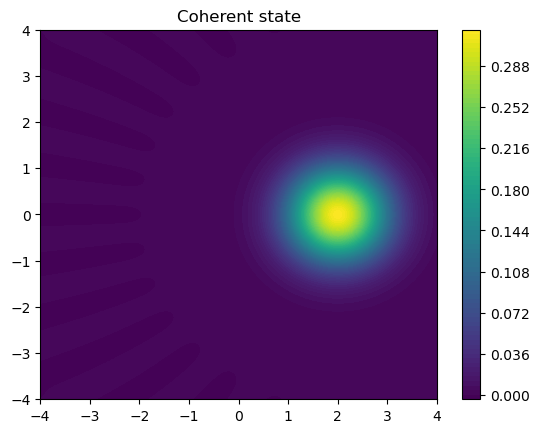

In [77]:
# Below we create the Wigner function using qtip and choose an x-space from -lnspc to lnspc with 200 points

lnspc = 4

xvec = np.linspace(-lnspc,lnspc,200)

W_coherent = qt.wigner(rho_coherent_dm, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We define the Wigner function. Below the coherent state is shifted by 45 degrees

In [78]:
# Simple rotation function

def rot(theta):
    return (1j*theta*qt.num(N)).expm()

# 1j is just i and rho_coherent is a vector (can be rotated as such)


#### As an example we consider the coherent state rotated by 45 degrees (pi/4)

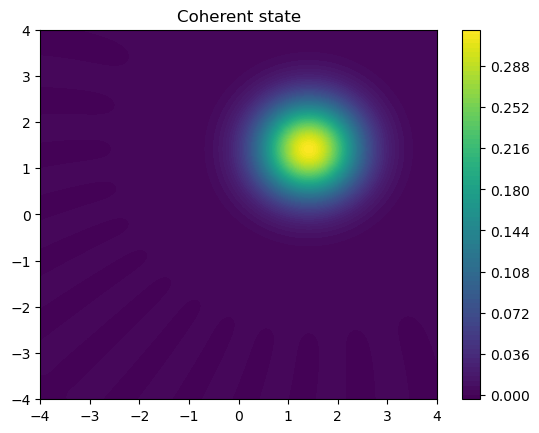

In [79]:
W_coherent = qt.wigner(rot(mt.pi/4)*rho_coherent, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We can do this process for different values of theta, here theta=[0,30,60,90,120,150,180]

In [80]:
num_thetas = [0,30,60,90,120,150,180]
thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(thetas)

W_coherents = [0]*N_thetas

# xs contains all the x values for different values of theta

xs = np.zeros((N_thetas,len(W_coherent[0])))

# The for loop below updates the xs array to contain the x-values (int over all p) at different angles

for i in range(N_thetas):
    W_coherents[i] = qt.wigner(rot(thetas[i])*rho_coherent, xvec, xvec)
    cohe = W_coherents[i]
    seq = np.array([np.sum(cohe[:,j]) * (xvec[1]-xvec[0])/20 for j in range(len(W_coherents[0][0]))])
    xs[i] = seq

##### Below, the values of p(x_theta) are shown for the different values of theta

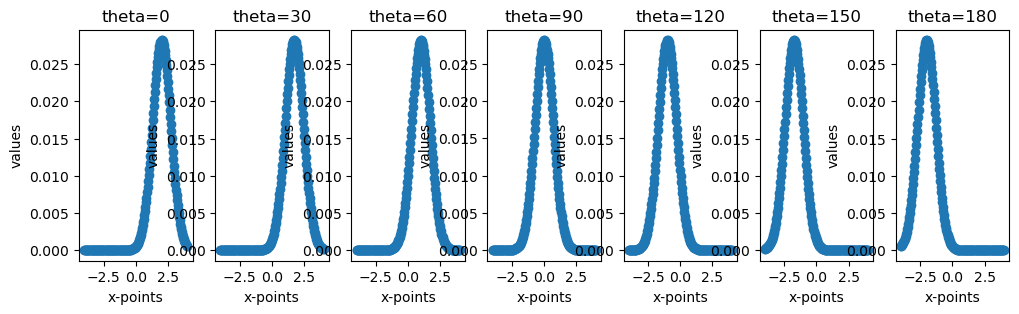

In [81]:
fig, axes = plt.subplots(1, 7, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[0])
scat1 = axes[1].scatter(xvec, xs[1])
scat2 = axes[2].scatter(xvec, xs[2])
scat3 = axes[3].scatter(xvec, xs[3])
scat4 = axes[4].scatter(xvec, xs[4])
scat5 = axes[5].scatter(xvec, xs[5])
scat6 = axes[6].scatter(xvec, xs[6])

i = 0

for ax in axes.flat:
    ax.set(xlabel='x-points', ylabel='values', title='theta=' + str(num_thetas[i]))
    i+=1

plt.show()

##### Now that we have different probability distributions for x we can use the rejection sampling technique

In [82]:
# Rejection sample function of an array of points

def Rsamp(arr, lnspcfnc):
    """arr is an array containing the given array of points
    lnspcfnc is the x-axis grid size (-lnspcfnc;lnspcfnc)"""

    maxval = max(arr)    
    Ry = np.random.uniform(0,maxval,200)
    xgrid = np.linspace(-lnspcfnc,lnspcfnc,200)
    indices = np.where(arr>Ry)
    Rsample = xgrid[indices]
    
    return Rsample

# For loop for iteration; maybe change (avoid for-loops)

def RepRsamp(iter,arr1,lnspcfnc):
    RsampIter = np.array([])
    for i in range(iter):
        RsampIter = np.append(RsampIter,Rsamp(arr1,lnspcfnc))
    return RsampIter

In [87]:
vals = Rsamp(xs[0], 4)
valsIter = RepRsamp(1000, xs[0],4)

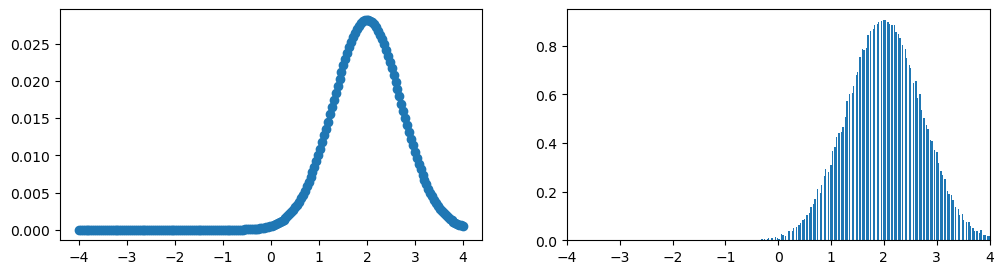

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[0])
hist1 = axes[1].hist(valsIter,bins=200, density=True, stacked=True)

plt.xlim(-lnspc,lnspc)
plt.show()

##### We use this method to have samples for all theta-values {0,30,60,90,120,150}

In [90]:
num_thetas = [0,30,60,90,120,150]
rad_thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(num_thetas)

samples_theta = [0] * N_thetas
lengths = []

iter = 100

# Since the length of the array depends on the sample we cannot make samples_theta into a numpy array
# Therefore we keep it as a list for now

for j in range(N_thetas):
    samples_theta[j] = RepRsamp(iter, xs[j], 4)


# Definition of Likelyhood-function

In [69]:
# Definition of the likelyHood-function

def likelyHood(pr,f):
    product = 1.
    for j in range(len(f)):
        product *= pr[j]**f[j]
    return product

# Overlap function defined as eq. 8 in the paper

def overlap(n,theta_index,x):
    """x corresponds to yi (measurement values)"""
    thetas = [0,30,60,90,120,150]
    theta = thetas[theta_index]
    hermit = sp.special.hermite(n)
    overl = np.real(cm.exp(1j * n * theta)) * (2./mt.pi)**(1/4) * hermit(mt.sqrt(2)*x)
    overl = overl/(mt.sqrt(2**n * mt.factorial(n)))*mt.exp(-x**2)
    return overl

# Creates (help)matrices to calculate the overlap

def CreateMatrixOverlap(rows,cols,theta_indx1,yjs):
    M = np.ones((rows,cols))

    for i in range(rows):
        for j in range(cols):
            M[i,j] = overlap(j,theta_indx1,yjs[i])
    return M

##### With the Likelyhood function we take as input a state operator (in this first case we know the state operator) and compute value. This value is largest (closest to one) for the correct state operator.

##### We can choose a value for theta_indx depending on what theta we look at

In [93]:
# We define theta_indx to be a dynamic variable (choose the sample of theta=0,30,60,90,120,150 by index)

# I should make this a dictionary

theta_indx = 0

sample = np.histogram(samples_theta[0],bins=100,density=True)

In [94]:
# fjs is our number of occurences

yjs = sample[1]
yjs = np.array(yjs)

fjs = sample[0]
fjs = np.array(fjs) #These values do not sum to 1!?

# We change it so they sum to one

fjsSum = np.sum(fjs)

fjsNormal = [i/fjsSum for i in fjs]

# Below we convert the density operator from type Qobj to type numpy-array

rho_coherent_dm = rho_coherent_dm.full()
rho_coherent_dm = np.real(np.array(rho_coherent_dm))

# What we are doing here is that we are updating yjs to only include the midpoint value
# of each bin which matches the dimension of fvals (i.e. we have the same number of j's)

for i in range(len(yjs)):
    if i < len(yjs)-1:
        yjs[i] = yjs[i] + (yjs[i+1] - yjs[i])/2

yjs = np.delete(yjs,-1)

# Dimensions of density operator, rho below. In our case the dimension of rho is 20 x 20

M = rho_coherent_dm.shape[0]
N = rho_coherent_dm.shape[1]

# This is our prjs; we update this later

prjs = np.zeros(len(fjsNormal))

##### Old derivation of overlaps (slow; takes app. 17s)

In [95]:
#K = len(prjs)

#for k in range(K):
#    sum = 0
#    for i in range(M):
#        for j in range(N):
#            seq = overlap(i,theta_indx,yjs[k]) * overlap(j,theta_indx,yjs[k]) * rho_coherent_dm[i,j]
#            sum += seq
#    prjs[k] = sum


##### Derivation using matrix multiplication (faster; takes app. 1.6s)

In [96]:
# Matrix multiplication to derive overlaps (much faster)

K = len(prjs)

Mnk = CreateMatrixOverlap(N,K,theta_indx,yjs)
Mkn = CreateMatrixOverlap(K,N,theta_indx,yjs)

val = np.dot(Mkn,rho_coherent_dm)
val = np.dot(val,Mnk)

for k in range(K):
    sumval = np.sum(val[k])
    prjs[k] = sumval

In [97]:
# The result does not seem correct

L = likelyHood(prjs,fjsNormal)
print(L)


0.0949836341850678


## Ensemble that maximizes the likelyhood, L

In [98]:
def MaxLik(f,pr,proj):
    sum = 0
    for i in range(len(f)):
        sum += f[i]/pr[i] * proj